In [1]:
# !pip install imblearn

- Natrajvikram Sivabalasubramanian ( AIS ) 

### Streamlit app

https://enviz-chess-position-streamlit-app-fqz2n4.streamlitapp.com/

### GitHub repo
https://github.com/enviz/chess_position_streamlit

### About the dataset

- link : https://www.kaggle.com/datasets/koryakinp/chess-positions
## Context
The goal of the project is to build a model able to generate FEN description based on a schematic image of a chess board.

#### Content
100000 images of a randomly generated chess positions of 5-15 pieces (2 kings and 3-13 pawns/pieces)
Images were generated using 28 styles of chess boards and 32 styles of chess pieces totaling 896 board/piece style combinations.

Images were generated using this custom-build tool

All images are 400 by 400 pixels.

Training set: 80000 images
Test set: 20000 images
Pieces were generated with the following probability distribution:

30% for Pawn
20% for Bishop
20% for Knight
20% for Rook
10% for Queen
2 Kings are guaranteed to be on the board.

Labels are in a filename in Forsyth–Edwards Notation format, but with dashes instead of slashes.

### Importing all the necessary Libraries

In [2]:
# Reference to the dataset and notebook : https://www.kaggle.com/datasets/koryakinp/chess-positions


import matplotlib.pyplot as plt
import numpy as np
import os  
import cv2
import keras


from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from random import sample,shuffle
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from skimage import io, transform
from skimage.util.shape import view_as_blocks
from collections import Counter
from PIL import Image, ImageOps
from imblearn.under_sampling import RandomUnderSampler

The usage of all the libraries used in this notebook are listed as follows:

- Numpy: Mathematical operations on arrays
- os : To get all the files in a given directory
- keras: Python library to build neural networks
- random: sampling
- skimage: image processing
- imblearn: Sampling


#### Load Train & Test Datasets

In [3]:
file=os.listdir('train/')
test_data=os.listdir('test/')

### Data Exploration

- Let's take a look  the dataset and the labels we downloaded from Kaggle
- Input : Chess board image with pawns and its positions

- Output : Forsyth–Edwards Notation (FEN) 


Forsyth–Edwards Notation is a standard notation for describing a particular board position of a chess game. 

The purpose of FEN is to provide all the necessary information to restart a game from a particular position. FEN is based on a system developed by Scottish newspaper journalist David Forsyth.

In [4]:
# Looking at train data structure
print(file[0:5])

['1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg', '1b1b1b2-3r4-1rK4b-R7-R2R1k2-2Bp4-2P5-2r5.jpeg', '1B1B1K2-3p1N2-6k1-R7-5P2-4q3-7R-1B6.jpeg', '1b1B1K2-R2B4-7P-3b4-3R2B1-8-3R4-4Qk2.jpeg', '1b1b1n2-1K1RN1b1-3pbN2-8-4q1k1-4P3-8-2n3N1.jpeg']


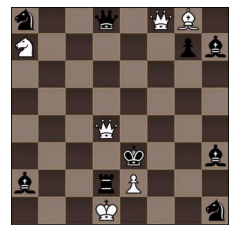

(400, 400, 3)


In [5]:
# view image sample
img = cv2.imread('train/n2q1QB1-N5pb-8-8-3Q4-4k2b-b2rP3-3K3n.jpeg')
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

print(img.shape)

### Data Preprocessing

- The general idea is to split each chessboard image into 64 images with each image corresponding to a single chess piece.
- We encode the labels of FEN into a 64 dimensional array with only integers


In [6]:
# Functions to encode chess piece labels

def tran(t):
    T={'B':0,'b':1,'K':2,'k':3,'Q':4,'q':5,'R':6,'r':7,'P':8,'p':9,'N':10,'n':11,'F':12}
    return T[t]

def tran_t(t):
    T={0:'B',1:'b',2:'K',3:'k',4:'Q',5:'q',6:'R',7:'r',8:'P',9:'p',10:'N',11:'n'}
    return T[t]

In [7]:
def labels_from_fen(name_t):
    #Convert FEN code to labels
    name_t=name_t.split('.')[0]
    po=name_t.split('-') # ['n2q1QB1', 'N5pb', '8', '8', '3Q4', '4k2b', 'b2rP3', '3K3n']
    index=np.zeros((8,8))

    for n in range(8):
        temp=[]
        for t in po[n]:
            if t>='1' and t<='8':
                for num in range(int(t)):
                    temp.append(int(12))
            elif t>='A' and t<='z':
                temp.append(tran(t))
        index[n,:]=np.intc(temp)

    return index.flatten()

In [8]:
# Sample extraction of encoded label data from an image
name_t='n2q1QB1-N5pb-8-8-3Q4-4k2b-b2rP3-3K3n.jpeg'
ans=labels_from_fen(name_t)
print(f"{ans.shape[0]} labels")
print(ans)

64 labels
[11. 12. 12.  5. 12.  4.  0. 12. 10. 12. 12. 12. 12. 12.  9.  1. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.  4.
 12. 12. 12. 12. 12. 12. 12. 12.  3. 12. 12.  1.  1. 12. 12.  7.  8. 12.
 12. 12. 12. 12. 12.  2. 12. 12. 12. 11.]


In [9]:
SQUARE_SIZE = 40 # must be less than 400/8 = 50
downsample_size = SQUARE_SIZE * 8
square_size = SQUARE_SIZE

def split_chessboard_into_64_images(image, mode='train'):
    #img_read = io.imread(f"../input/chess-positions/dataset/{mode}/{image}")
    img_read = cv2.imread(mode+'/'+image,cv2.IMREAD_GRAYSCALE)
    img_read = transform.resize(img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size))
    #print(tiles.shape)
    #tiles = tiles.squeeze(axis=2)
    tiles =  tiles.reshape(64, square_size, square_size)
    #print(tiles.shape)
    return tiles.tolist()

(64, 40, 40)


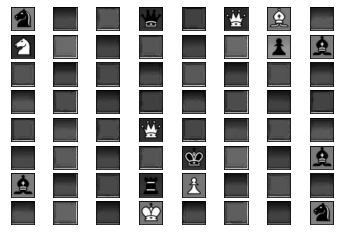

In [10]:
# Visualizing Splitted Chessboard image into 64 images
single_image = split_chessboard_into_64_images('n2q1QB1-N5pb-8-8-3Q4-4k2b-b2rP3-3K3n.jpeg')
tiles = np.array(single_image)
print(tiles.shape)
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(tiles[i][:][:][:],cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

### Optimizing the training process

- Since we have more than 80000 datapoints , we need to load each one of them in batches.
- We introduce a function that we will yield a new  batch with image and its corresponding label at every iteration of the training process. 
- We do this so that it's computationally efficient.

In [11]:
def generator(samples, batch_size=1000):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    undersample = RandomUnderSampler(random_state=0)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)

        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = file[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for i,image in enumerate(batch_samples):
                # Load image (X) and label (y)
                if i==0:
                    X_train = split_chessboard_into_64_images(image)
                else:
                    X_train = np.concatenate((X_train, split_chessboard_into_64_images(image)))

                y_train = np.concatenate((y_train, labels_from_fen(image)))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            reshaped_X = X_train.reshape(X_train.shape[0],-1)
            reshaped_X, y_train = undersample.fit_resample(reshaped_X, y_train)
            X_train = reshaped_X.reshape(-1,40,40)
            
            X_train = X_train.reshape(X_train.shape + (1,))
            y_train = np.array(y_train)
            y_train = np_utils.to_categorical(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

### Model Training

In [12]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding='same',input_shape=(40,40,1)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dropout(0.5))
cnn.add(Dense(13, activation="softmax"))
cnn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 32)        320       
                                                                 
 activation (Activation)     (None, 40, 40, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5184)              0

In [14]:
len(file)

80000

In [15]:
shuffle(file)
train_samples = file[:80000]

train_generator = generator(train_samples, batch_size=100)
cnn.fit(train_generator, steps_per_epoch=100, epochs=2)

Epoch 1/2
100/100 [==============================] - 311s 3s/step - loss: 0.7247 - accuracy: 0.8175
Epoch 2/2
100/100 [==============================] - 285s 3s/step - loss: 0.0510 - accuracy: 0.9915


In [18]:
cnn.save("streamlit_app/chess_model.h5")


In [20]:
test_image = sample(file, 1)
x_train = split_chessboard_into_64_images(test_image[0])
x_train = np.array(x_train)

test = x_train
test = test.reshape(test.shape + (1,))
print(test.shape)
pred = cnn.predict(test)
pred = pred.argmax(axis=1).reshape(-1, 8, 8)

(64, 40, 40, 1)


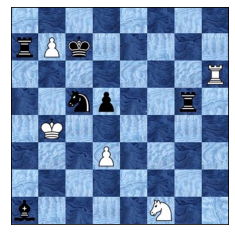

Pred Label: 8-rPk5-7R-2np2r1-1K6-3P4-8-b4N2
True Label: 8-rPk5-7R-2np2r1-1K6-3P4-8-b4N2


In [23]:
# Print model prediction with image
img = cv2.imread('train/'+test_image[0])
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

print(f"Pred Label: {fen_from_onehot(pred[0])}")
print(f"True Label: {test_image[0].split('.')[0]}")

### Performance Evaluation

In [24]:
# Test Data Generator

def test_data_generator(n_samples=1000):
    
    data = test_data[:n_samples]
    y_test = []
    x_test = []
    undersample = RandomUnderSampler(random_state=0)

    for i,image in enumerate(data):
        if i==0:
            x_test = split_chessboard_into_64_images(image, mode='test')
        else:
            x_test = np.concatenate((x_test, split_chessboard_into_64_images(image, mode='test')))

        y_test = np.concatenate((y_test, labels_from_fen(image)))

    x_test = np.array(x_test)
    reshaped_X = x_test.reshape(x_test.shape[0],-1)
    # print(Counter(y_test))
    reshaped_X, y_test = undersample.fit_resample(reshaped_X, y_test)
    new_X = reshaped_X.reshape(-1,40,40)
    x_test = new_X
    x_test = x_test.reshape(x_test.shape + (1,))
    y_test = np_utils.to_categorical(y_test)
    # print(x_test.shape, y_test.shape)
    # print(Counter(y_test))
    return x_test, y_test

In [25]:
x, y = test_data_generator()
score = cnn.evaluate(x, y)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

175/175 [==============================] - 1s 7ms/step - loss: 0.0203 - accuracy: 0.9987
Test loss: 0.020299028605222702 / Test accuracy: 0.9987477660179138


In [26]:
cnn.save("chess_model.h5")